# A Hybrid Framework for Person Classification in CCTV with Low Resources

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import matplotlib.pyplot as plt
import os
import sys


from matplotlib.patches import Rectangle
from datasets.prw import PRWRawDataset, PRWClassification
from models.utils import load_model_and_transforms
from config.config import ModelArgs, RootArgs, DatasetArgs, TrainingArgs, TestArgs, LogArgs, save_cfg, CN
from torchinfo import summary
from ipywidgets import widgets, interact
from pathlib import Path

sys.argv = [""]
if "../intrusion-detection-project/src" not in sys.path:
    sys.path.insert(0, "../intrusion-detection-project/src")

In [3]:
training_args = TrainingArgs(
    {
        "log": LogArgs({"run_path": "runs/customnet3/"}),
        "accumulation_steps": 1,
        "early_stopping_patience": 0,
        "eval_batch_size": 512,
        "eval_num_repetitions": 3,
        "lr": 1.0e-03,
        "metric_for_best_model": "mu_val_loss",
        "mode": "min",
        "num_epochs": 500,
        "num_workers": 6,
        "train_batch_size": 512,
    }
)

model_args = ModelArgs({"name": "customnet3"})

data_args = DatasetArgs(
    {
        "dataset_name": "prw-classification",
        "root_path": "../data/PRW/",
    }
)

test_args = TestArgs(
    {
        "num_workers": 4,
        "test_batch_size": 512,
        "test_num_repetitions": 33,
    }
)

cfg = RootArgs({"dataset": data_args, "model": model_args, "training": training_args, "test": test_args})

Download the dataset from [here](https://liveunibo-my.sharepoint.com/:u:/g/personal/lorenzo_pratesi2_studio_unibo_it/Ee4cCXt87Z1EroyCuKrpu6IBCk3thoi7tw7ungBBEDDNag?e=pSQjhd) (you need UNIBO credentials) and extract it in <code><workspace_path>/data/</code>.

In [3]:
# PRW setup scripts (will take a while...)
!cd .. && \
    export PYTHONPATH=./intrusion-detection-project/src && \
    python -m src.scripts.PRW.create_bad_bboxes data/PRW && \
    python -m src.scripts.PRW.create_negatives data/PRW --num_clusters=4 && \
    python -m src.scripts.PRW.create_positives data/PRW && \
    python -m src.scripts.PRW.create_yolov5_dataset data/PRW data/PRW/detection 


100%|███████████████████████████████████████| 6112/6112 [08:02<00:00, 12.66it/s]


## Introduction

### ???
Detecting people in CCTV videos is crucial many for video security systems. Many video surveillance cameras are static, capturing the same visual space over time, and are often handled by embedded systems with limited computational power. Existing algorithms are able to solve the task with great accuracy, but are relatively computationally expensive for such systems. This work proposes a hybrid framework for person detection in static camera environments that decouples the detection task in region proposal through background subtraction and human classification with a CNN. The aim is to solve the person detection task for a specific domain with low computational resources.

In the realm of computer vision, the advent of deep learning has led to remarkable breakthroughs in object detection. However, the widespread deployment of these sophisticated models on resource-constrained embedded systems remains a challenge. The constraints imposed by low-end hardware components demand innovative solutions that balance accuracy and efficiency, catering to specific domains where the application is constrained to operate.

This project introduces a domain-specific people detection framework that embraces the limitations of low-end hardware while achieving a high level of performance within its designated domain. We recognize that deploying complex models like YOLOv5 on embedded systems with modest computing power can lead to inefficiencies and compromises in speed and responsiveness. To address this, our framework is designed to be tailor-made for the intended domain, achieving a good trade-off between precision and efficiency.

It is important to note that our framework operates within a bounded domain, which is a key distinguishing factor. The domain-specific nature of our approach ensures that it excels in the designated domain while potentially struggling to generalize outside of it. This trade-off is a deliberate choice, prioritizing optimization for a specific task and context.

### Methods
The proposed method is the following: we pick the first N frames to produce a grayscale background image. Each frame is spatially bilinearly interpolated to a target resolution (144x192). This is the resolution with which the background subtraction algorithm works. The algorithm subtract every new frame from the background image to produce a binary mask. Candidate regions of the frame are computed as the smallest rectangle bounding box that encloses each connected component of the binarized frame. 

We extract a patch from the original frame from each proposed region. The patch is processed by a CNN trained for binary classification. The model will predict if the region contains a person or not. In the following section, there will be explained how the CNN model is trained.

## Experimental Setup

### Dataset: Person Re-identification in the Wild (PRW)

PRW is a dataset for person re-identification, that is, identifying people in visual scenes given the image of a person as query. The dataset consists in 11816 frames with 34304 annotated boxes, with 932 different identities. Frames are captured using 6 different CCTV static cameras, allowing the use of background subtraction algorithms. Although the dataset is devised of person re-identification, its nature is suitable for our experimental setting, since it contains frames with annotated humans captured sequentially using static cameras.

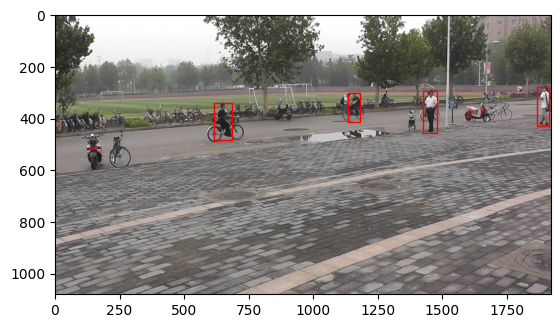

In [4]:
### An example of a PRW frame
data_raw = PRWRawDataset(root_path=data_args.root_path, shuffle=False)

idx = random.randint(0, len(data_raw) - 1)
img, boxes, video_id = data_raw[idx]

_, ax = plt.subplots()

ax.imshow(img)
for box in boxes:
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"))

plt.show()

### PRW preprocessing for person classification

This section will describe the PRW pre-processing techniques used to implement a binary classification training pipeline. 

For each frame, a patch centering each person is sampled. Those patches will be the **positives** samples of the new pre-processed dataset. To sample **negatives**, we sample the same number of positive patches randomly from the frame, smaking sure that they do not contain any human. Negatives are randomly sampled at runtime during training, so to prevent early overfitting issues and increase generalization of the models. 

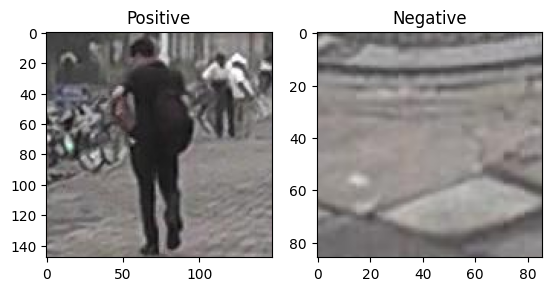

In [65]:
### An example of positive and negative samples

data_classification = PRWClassification(root_path=data_args.root_path)
pos_idx = random.randint(0, len(data_classification.positives) - 1)
neg_idx = random.randint(0, len(data_classification.negatives) - 1)
pos_example, _ = data_classification.positives[pos_idx]
neg_example, _ = data_classification.negatives[neg_idx]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(pos_example.permute(1, 2, 0))
ax[0].set_title("Positive")
ax[1].imshow(neg_example.permute(1, 2, 0))
ax[1].set_title("Negative")
plt.show()

### Background Subtraction Algorithm
In this section, an example of the background subraction algorithm applied on the PRW dataset will be showed.

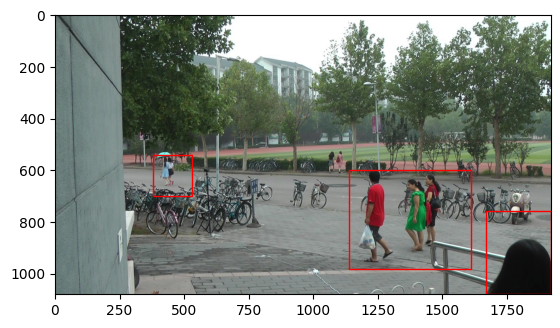

Button(description='Next frame', style=ButtonStyle())

In [54]:
from utils import BackgroundSubtractionForDetection
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

data_raw = PRWRawDataset(root_path=data_args.root_path, shuffle=False, split="test")
target_shape = (144, 192)  # Resolution with which the background subtraction algorithm works
current_video_id = (0, 0)  # Static camera identifier
num_background_samples = 20
frame_id = 0


def collect_background_samples(data_raw, start_frame_id, num_background_samples=20):
    background_samples = []
    for i in range(start_frame_id, start_frame_id + num_background_samples):
        frame, _, _ = data_raw[i]
        background_samples.append(frame)
    return background_samples


def new_frame(button):
    global frame_id, current_video_id, backgorund_subtraction
    clear_output()
    if data_raw.annotations[frame_id]["video_id"] > current_video_id:
        background_samples = collect_background_samples(data_raw, frame_id, num_background_samples)
        backgorund_subtraction = BackgroundSubtractionForDetection(
            background_samples=background_samples,
            target_shape=target_shape,
        )
        frame_id += num_background_samples
        current_video_id = data_raw.annotations[frame_id]["video_id"]
    frame, _, _ = data_raw[frame_id]
    candidate_boxes = backgorund_subtraction.step(frame)
    frame_id += 1
    _, ax = plt.subplots()
    ax.imshow(frame)
    for box in candidate_boxes:
        x, y, w, h = box
        ax.add_patch(Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"))
    plt.show()
    display(button)


button = widgets.Button(description="Next frame")
button.on_click(new_frame)
display(button)

### Models

The CNN models have been designed to be as simple and fast as possible. All the models are composed by sequential stacks of 3x3 2D convolution followed by Batch Norm, ReLU and max pool layers. The last activations are flattened ad processed by a linear layer with one unit output. 

With the following cell you can explore each implemented model. They have been designed so that they can process different image resolutions, specifically 128x128, 64x64 and 32x32.

In [67]:
cb = widgets.Combobox(
    placeholder="Choose CNN model",
    options=["customnet", "customnet2", "customnet3"],
    description="Model name:",
    ensure_option=True,
    disabled=False,
)


def submit(w):
    name = str(w)
    if name:
        temp_model_args = ModelArgs()
        temp_model_args.name = name
        model, train_transforms_fn, _ = load_model_and_transforms(model_args=temp_model_args)
        model = model.model
        print(summary(model, (1, 3) + train_transforms_fn.transforms[0].size))


interact(submit, w=cb)

interactive(children=(Combobox(value='', description='Model name:', ensure_option=True, options=('customnet', …

<function __main__.submit(w)>

### Training

In [56]:
%load_ext tensorboard

In [58]:
### Run Tensorboard widget
%tensorboard --logdir runs/

Reusing TensorBoard on port 6006 (pid 52963), started 0:00:06 ago. (Use '!kill 52963' to kill it.)

In [59]:
import train

save_cfg(cfg=cfg, dirpath=".", filename="hparams.yaml")
args = CN(
    {
        "cfg_path": "hparams.yaml",
        "random_seed": 42,
        "ckpt_path": None,
    }
)
train.train(args)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/prahtz/workspace/lr-human-detection/env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Evaluation

In [60]:
# Training configuration file path, containing model checkpoint info.
# NOTE: if you run multiple trainings, the version number MUST be incremented (e.g. version_0 -> version_1)
version_number = 0
log_path = Path(training_args.log.run_path) / f"version_{version_number}/config/test.yaml"
log_path = str(log_path)

In [61]:
from evaluate import evaluate

args = CN({"cfg_path": log_path, "random_seed": 42})  # default

evaluate(args)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
from evaluate_with_bs import evaluate_with_bs

args = CN({"cfg_path": log_path})

evaluate_with_bs(args)

100%|██████████| 6112/6112 [03:42<00:00, 27.41it/s]

Average Precisions: {'AP@0.5': tensor(0.8302), 'AP@0.55': tensor(0.8098), 'AP@0.6': tensor(0.7876), 'AP@0.65': tensor(0.7587), 'AP@0.7': tensor(0.7294), 'AP@0.75': tensor(0.6990), 'AP@0.8': tensor(0.6694), 'AP@0.85': tensor(0.6366), 'AP@0.8999999999999999': tensor(0.6025), 'AP@0.95': tensor(0.5685)}
Average backgroud subtraction time: 0.006580444056661229
Average model inference time: 0.0010201912539955344
Average total time: 0.012456474965470294


### YOLOv5n

In [5]:
del sys.modules["models"]  # Module names conflict workaround
import yolov5
import yolov5.train
from torchinfo import summary

model = yolov5.load("ultralytics/yolov5n.pt")
summary(model.model)

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



Layer (type:depth-idx)                                  Param #
DetectMultiBackend                                      --
├─DetectionModel: 1-1                                   --
│    └─Sequential: 2-1                                  --
│    │    └─Conv: 3-1                                   (1,760)
│    │    └─Conv: 3-2                                   (4,672)
│    │    └─C3: 3-3                                     (4,800)
│    │    └─Conv: 3-4                                   (18,560)
│    │    └─C3: 3-5                                     (29,184)
│    │    └─Conv: 3-6                                   (73,984)
│    │    └─C3: 3-7                                     (156,928)
│    │    └─Conv: 3-8                                   (295,424)
│    │    └─C3: 3-9                                     (296,448)
│    │    └─SPPF: 3-10                                  (164,608)
│    │    └─Conv: 3-11                                  (33,024)
│    │    └─Upsample: 3-12                 

In [ ]:
yolo_cfg = {
    # Dataset paths
    "path": str((Path(data_args.root_path) / "detection").absolute()),
    "train": "images/train",
    "val": "images/valid",
    "test": "images/test",
    # Number of classes
    "nc": 1,
    # Class names
    "names": ["person"],
}
save_cfg(cfg=CN(yolo_cfg), dirpath=".", filename="prw_yolov5.yaml")
yolov5.train.run(weights="ultralytics/yolov5n.pt", data="prw_yolov5.yaml", freeze=20)

In [ ]:
# Evaluation

from evaluate_yolo import evaluate_yolo

args = CN({"model_source": "yolov5n.pt", "data_path": data_args.root_path})
evaluate_yolo(args)

### Results